In [ ]:
# 1. Confirmed that at pH 8.5, the NE1 nitrogen in histidine is protonated based on experimental data. 
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4082993/

# 2. Changed aminoacids.c.tdb OH to OH1. Potential typo in force field files.

In [ ]:
# using hydrogen mass repartitioning for longer timesteps
gmx_mpi pdb2gmx -f ab40.pdb -o template.gro -ignh -heavyh -water tip3p

gmx_mpi pdb2gmx -f ab40.pdb -o template.gro -water tip3p -ignh

gmx_mpi editconf -f ../template.gro -o template_newbox.gro -c -d 2 -bt dodecahedron

gmx_mpi solvate -cp template_newbox.gro -cs spc216.gro -o template_solv.gro -p ../topol.top


In [ ]:
# following Alice's instructions to collapse the protein
# 1 – energy minimisation

# 2 – position restraints

# 3 – Berendsen, using the .mdp file I attached below at 310K (this won’t collapse the structure, it’s just a step before to equilibrate)

# 4 – NVT 600K to get the collapsed structure

In [ ]:
# Step 1
gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c template_solv.gro -p ../topol.top -o em_input.tpr -maxwarn 2

# Got the following warning
# WARNING 1 [file ffnonbonded.itp, line 68]:
#   Atomtype OT was defined previously (e.g. in the forcefield files), and
#   has now been defined again. This could happen e.g. if you would use a
#   self-contained molecule .itp file that duplicates or replaces the
#   contents of the standard force-field files. You should check the contents
#   of your files and remove such repetition. If you know you should override
#   the previous definition, then you could choose to suppress this warningb
#   with -maxwarn.

gerun gmx_mpi mdrun -s em -v -maxh 10 &> em_terminal.log

In [ ]:
# Step 2

gmx_mpi grompp -f ../mdp_files/2-pr.mdp -c em_output.gro -r em_output.gro -p ../topol.top -o 2-pr.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 2-pr -v &> 2-pr_terminal.log

In [ ]:
# Step 3

gmx_mpi grompp -f ../mdp_files/3-berendsen_1.mdp -c 2-pr.gro -r 2-pr.gro -p ../topol.top -o 3-berendsen.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 3-berendsen -v &> 3-berendsen-terminal.log

In [ ]:
# Step 4

gmx_mpi grompp -f ../mdp_files/4-nvt-600.mdp -c 3-berendsen.gro -r 3-berendsen.gro -p ../topol.top -o 4-nvt-600.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm 4-nvt-600 -v &> 4-nvt-600-terminal.log

# restarting step 4
gerun gmx_mpi mdrun -cpi 4-nvt-600 -deffnm 4-nvt-600 -v &> 4-nvt-600-terminal-r2.log

In [ ]:
# copied the .gro file produced to visualize the structure. More than one peptides present.
scp -o ProxyJump=zcbtar9@ssh-gateway.ucl.ac.uk zcbtar9@kathleen.rc.ucl.ac.uk:~/projects/amyloid-beta-research/ab40/system/setup/4-nvt-600.gro .

In [ ]:
# Tried extracting collapsed structure from output .gro file. Didn't because structure was split at edges

gmx_mpi make_ndx -f 4-nvt-600.gro -o collapsed-index.ndx

> a 1-598  # Adjust the atom range as needed for your protein
> q 

gmx_mpi trjconv -f 4-nvt-600.gro -s 4-nvt-600.gro -o collapsed-ab40.gro -n collapsed-index.ndx

scp -o ProxyJump=zcbtar9@ssh-gateway.ucl.ac.uk zcbtar9@kathleen.rc.ucl.ac.uk:~/projects/amyloid-beta-research/ab40/system/setup/collapsed-ab40.gro .

In [10]:
# extracting collapsed structure from trajectory using mdtraj


import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

topology=f"4-nvt-600.gro"
trajectory=f"4-nvt-600.trr"

trj = md.load(trajectory, top=topology,stride=1)
trj = trj.atom_slice(range(598))
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

print(n_frames)

frame = trj[454]
frame.save('454.gro')

In [ ]:
# procedure to extract 48 confirmations

# 1. adding water molecules
gmx_mpi editconf -f collapsed-ab40.gro -o template_newbox.gro -c -d 1.3 -bt dodecahedron
gmx_mpi solvate -cp template_newbox.gro -cs spc216.gro -o template_solv.gro -p ../topol.top

# 2. adding ions
gmx_mpi grompp -f ../mdp_files/ions.mdp -c template_solv.gro -p ../topol.top -o genion_NaCl_input.tpr -maxwarn 2
# WARNING 2 [file topol.top, line 5632]:
#   96 non-matching atom names
#   atom names from ../topol.top will be used
#   atom names from template_solv.gro will be ignored
gmx_mpi genion -s genion_NaCl_input.tpr -o genion_NaCl_output.gro -conc 0.137 -pname NA -nname CL -p ../topol.top

gmx_mpi grompp -f ../mdp_files/ions.mdp -c genion_NaCl_output.gro -p ../topol.top -o genion_KCl_input.tpr -maxwarn 1
gmx_mpi genion -s genion_KCl_input.tpr -o genion_KCl_output.gro -conc 0.00268 -pname K -nname CL -p ../topol.top
# no KCl ions added

# 3. Energy minimization
gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c  genion_KCl_output.gro -p ../topol.top -o em.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm em -v -maxh 11 &> em-terminal.log

# 4. position restraints
gmx_mpi grompp -f ../mdp_files/2-pr.mdp -c em.gro -r em.gro -p ../topol.top -o 2-pr.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 2-pr -v &> 2-pr-terminal.log
gmx_mpi mdrun -deffnm 2-pr -rcon 1.5 -dds 0.8 -v &> 2-pr-terminal.log
# There is no domain decomposition for 60 ranks that is compatible with the
# given box and a minimum cell size of 1.37088 nm
# Change the number of ranks or mdrun option -rcon or -dds or your LINCS
# settings
# Look in the log file for details on the domain decomposition

# Changed the number of ranks to 42 and increased box size to 1.3 nm

# 5. Berendsen
gmx_mpi grompp -f ../mdp_files/3-berendsen_1.mdp -c 2-pr.gro -r 2-pr.gro -p ../topol.top -o 3-berendsen.tpr -maxwarn 3
gerun gmx_mpi mdrun -deffnm 3-berendsen -v &> 3-berendsen-terminal.log

# 6. nvt-600
gmx_mpi grompp -f ../mdp_files/5-nvt-600.mdp -c 3-berendsen.gro -r 3-berendsen.gro -p ../topol.top -o 5-nvt-600.tpr -maxwarn 2
gerun gmx_mpi mdrun -deffnm 5-nvt-600 -v &> 5-nvt-600-terminal.log


In [ ]:
# trying to center the trajectory with gromacs
gmx_mpi trjconv -s 5-nvt-600.tpr -f 5-nvt-600.trr -o 5-nvt-600-noPBC-test.trr -pbc mol -center

In [ ]:
# checking contacts the peptide and its periodic images to see if box size is large enough
gmx_mpi mindist -f 5-nvt-600.trr -s 5-nvt-600.gro -pi

# The shortest periodic distance is 1.44846 (nm) at time 524 (ps),
# between atoms 107 and 591

Text(0.5, 1.0, 'Distance between peptide and its periodic image')

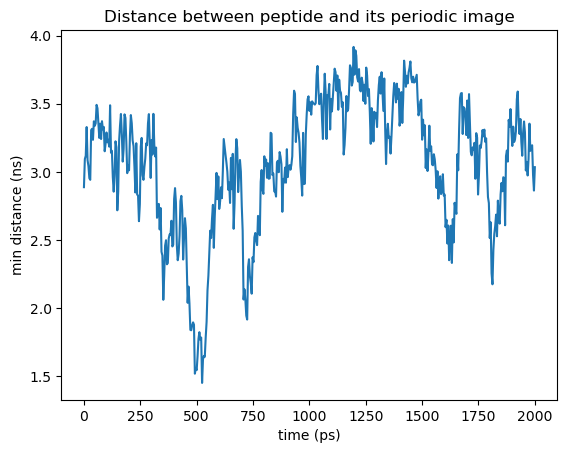

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_table("mindist.xvg", delim_whitespace=True, skiprows=29, header=None)
# dataA = dataA.drop(columns="Unnamed: 0")
x = data[0]
y = data[1]

fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_xlabel("time (ps)")  # Add an x-label to the axes.
ax.set_ylabel("min distance (ns)")  # Add a y-label to the axes.
ax.set_title("Distance between peptide and its periodic image")

In [24]:
# extracting 48 confirmations

# algorithm to extract 48 confirmations

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

topology=f"5-nvt-600.gro"
trajectory=f"5-nvt-600-noPBC-more-frames.trr"

In [25]:
trj = md.load(trajectory, top=topology,stride=1)
trj2 = trj.atom_slice(range(598))
# trj.center_coordinates()
top = trj2.topology
first_frame = 0
n_frames=trj.n_frames

n_frames

501

In [16]:
# frame = trj[0]
# frame.save('5-nvt-600-noPBC-no-water-mf-frame1.gro')
# trj.save_trr('5-nvt-600-no-water-mf.trr')

# trj2 = trj.slice(range(0, 2001, 10))
# print(trj2.n_frames)

In [2]:
# nres=[]



# for res in trj.topology.residues: nres.append(res.resSeq)
# sequence=(' %s' % [residue for residue in trj.topology.residues])
# resname=(' %s' % [residue.name for residue in trj.topology.residues])
# resindex=(' %s' % [residue.index for residue in trj.topology.residues])
# res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



# #log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
# # print("** SYSTEM INFO **\n")
# # print("Number of atoms: %d\n" % trj.n_atoms)
# # print("Number of residues: %d\n" % len(set(nres)))
# # print("Number of frames: %d\n" % trj.n_frames)
# # print("Starting frame: %d\n" % first_frame)
# # print("Last frame: %d\n" % last_frame)
# # print("sequence: %s\n" % sequence)
# # print("residue names: %s\n" % resname)
# # print("residue number: %s\n" % res_num)
# # print("residue index: %s\n" % resindex)
# resname = [residue.name for residue in trj.topology.residues]
# resname
# # DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVVIA
# # DAEFRHDSGYEVHHQKLVFFAEDVGSNKGAIIGLMVGGVV
# # print(''.join(resname))

In [3]:
# rmsd = md.rmsd(trj2, trj2, 0)
# # print(max(rmsd))
# rmsd = md.rmsd(trj2, trj2, 0)

# # Find the index of the maximum value
# max_index = np.argmax(rmsd)
# max_index

In [34]:
# # https://stackoverflow.com/questions/63321109/algorithm-for-selecting-a-subset-of-most-distant-elements
def find_largest_values(trj, N, M):
    candidates = []  # List to store pairs (j, l(j))
    S_prime = []  # Resulting subset

    # Calculate pairwise distances and initialize candidates list
    for i in range(N):
            rmsd = md.rmsd(trj, trj, i)
#             print(rmsd)
            rmsd = np.delete(rmsd, i)

            l_i = min(rmsd)
            candidates.append((i, l_i))

    # Sort candidates list by l(i) in descending order
    candidates.sort(key=lambda x: x[1], reverse=True)

    # Select M elements with the largest values of l(i)
    for i in range(M):
        current_index, current_l_value = candidates[i]
        S_prime.append(current_index)

    return S_prime

indxs = find_largest_values(trj2, trj2.n_frames, 50)
indxs

[479,
 110,
 165,
 397,
 408,
 123,
 243,
 92,
 71,
 182,
 407,
 22,
 109,
 88,
 97,
 87,
 456,
 444,
 393,
 58,
 59,
 50,
 98,
 99,
 453,
 156,
 423,
 390,
 440,
 183,
 399,
 398,
 135,
 39,
 469,
 114,
 166,
 167,
 74,
 75,
 37,
 38,
 57,
 136,
 242,
 53,
 54,
 437,
 163,
 164]

In [33]:
for i in range(40):
    trj[indxs[i]].save(f'../production/r{i}/template.gro')

In [ ]:
# after extracting 48 confirmations, setup the system for production run

# 1. Energy Minimization
gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c r0/template.gro -p ../topol.top -o r0/em.tpr
for i in {1..39}; do gmx_mpi grompp -f ../mdp_files/0-em-steep.mdp -c r${i}/template.gro -p ../topol.top -o r${i}/em.tpr; done

# 2. NVT

# 3. NPT